In [23]:
# Data
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import impl.layer as l

# Dataset preparation and pre-processing
mnist = input_data.read_data_sets('data/MNIST_data/', one_hot=False)

X_train, y_train = mnist.train.images, mnist.train.labels
X_val, y_val = mnist.validation.images, mnist.validation.labels
X_test, y_test = mnist.test.images, mnist.test.labels

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [24]:
# Pre-processing: normalizing
def normalize(X):
    # max scale for images 255= 2**8= 8 bit grayscale for each channel
    return (X - X.mean(axis=0)) #/ X.std(axis=0)

X_train, X_val, X_test = normalize(X=X_train), normalize(X=X_val), normalize(X=X_test)

In [25]:
import impl.layer as l
from sklearn.utils import shuffle as skshuffle

class FFNN:

    def __init__(self, D, C, H, L):
        self.L = L # layers
        self.C = C # classes
        self.losses = {'train':[], 'train_acc':[], 
                       'valid':[], 'valid_acc':[], 
                       'test':[], 'test_acc':[]}
        
        self.model = []
        self.W_fixed = []
        self.grads = []
        low, high = -1, 1
        
        # Input layer: weights/ biases
        m = dict(W=np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.), b=np.zeros((1, H)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.)
        self.W_fixed.append(m)
        # Input layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[0].items()})

        # Hidden layers: weights/ biases
        m_L = []
        for _ in range(L):
            m = dict(W=np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, H)))
            m_L.append(m)
        self.model.append(m_L)
        # Fixed feedback weight
        m_L = []
        for _ in range(L):
            m = np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.)
            m_L.append(m)
        self.W_fixed.append(m_L)
        # Hidden layer: gradients
        grad_L = []
        for _ in range(L):
            grad_L.append({key: np.zeros_like(val) for key, val in self.model[1][0].items()})
        self.grads.append(grad_L)
        
        # Output layer: weights/ biases
        m = dict(W=np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, C)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.)
        self.W_fixed.append(m)
        # Output layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[2].items()})
        
    def fc_forward(self, X, W, b):
        out = (X @ W) + b
        cache = (W, X)
        return out, cache

    def fc_backward(self, dout, cache):
        W, X = cache

        dW = X.T @ dout
        db = np.sum(dout, axis=0).reshape(1, -1) # db_1xn

        return dW, db

    def train_forward(self, X, train):
        caches, ys = [], []
        
        # Input layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[0]['W'], b=self.model[0]['b']) # X_1xD, y_1xc
        y, nl_cache = l.tanh_forward(X=y)
        X = y.copy() # pass to the next layer
        if train:
            caches.append((fc_cache, nl_cache))
        
        # Hidden layers
        fc_caches, nl_caches = [], []
        for layer in range(self.L):
            y, fc_cache = self.fc_forward(X=X, W=self.model[1][layer]['W'], b=self.model[1][layer]['b'])
            y, nl_cache = l.tanh_forward(X=y)
            X = y.copy() # pass to next layer
            if train:
                fc_caches.append(fc_cache)
                nl_caches.append(nl_cache)
        if train:
            caches.append((fc_caches, nl_caches)) # caches[1]            
        
        # Output layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[2]['W'], b=self.model[2]['b'])
        y_prob = l.softmax(X=y)
        if train:
            caches.append(fc_cache)

        return y_prob, caches

    def cross_entropy(self, y_prob, y_train):
        m = y_prob.shape[0]

        #         prob = l.softmax(y_pred)
        log_like = -np.log(y_prob[range(m), y_train]) # to avoid the devision by zero
        data_loss = np.sum(log_like) / m

        return data_loss

    def dcross_entropy(self, y_prob, y_train): # this is equal for both since the reg_loss (noise) derivative is ZERO.
        m = y_prob.shape[0]

        #         grad_y = l.softmax(y_pred)
        grad_y = y_prob
        grad_y[range(m), y_train] -= 1.
        grad_y /= m

        return grad_y

    def loss_function(self, y_prob, y_train):
        
        loss = self.cross_entropy(y_prob, y_train) # softmax is included
        dy = self.dcross_entropy(y_prob, y_train) # dsoftmax is included

        return loss, dy
        
    def train_backward(self, dy, caches, y):
        grads = self.grads.copy() # initialized by Zero in every iteration/epoch
        
        # Output layer
        fc_cache = caches[2]
        # softmax_backward is included in dcross_entropy.
        dW, db = self.fc_backward(dout=dy, cache=fc_cache)
        dy = dy @ self.W_fixed[2].T # FBA
        grads[2]['W'] = dW
        grads[2]['b'] = db

        # Hidden layer
        fc_caches, nl_caches = caches[1]
        for layer in reversed(range(self.L)):
            dy = l.tanh_backward(cache=nl_caches[layer], dout=dy) # diffable function
            dW, db = self.fc_backward(dout=dy, cache=fc_caches[layer])
            dy = dy @ self.W_fixed[1][layer].T # FBA
            grads[1][layer]['W'] = dW
            grads[1][layer]['b'] = db
        
        # Input layer
        fc_cache, nl_cache = caches[0]
        dy = l.tanh_backward(cache=nl_cache, dout=dy) # diffable function
        dW, db = self.fc_backward(dout=dy, cache=fc_cache)
        grads[0]['W'] = dW
        grads[0]['b'] = db

        return grads
    
    def test(self, X):
        y_prob, _ = self.train_forward(X, train=False)
        
        # if self.mode == 'classification':
        y_pred = np.argmax(y_prob, axis=1) # for loss ==err
        
        return y_pred, y_prob
        
    def get_minibatch(self, X, y, minibatch_size, shuffle):
        minibatches = []

        if shuffle:
            X, y = skshuffle(X, y)

        for i in range(0, X.shape[0], minibatch_size):
            X_mini = X[i:i + minibatch_size]
            y_mini = y[i:i + minibatch_size]
            minibatches.append((X_mini, y_mini))

        return minibatches

    def sgd(self, train_set, val_set, alpha, mb_size, n_iter, print_after):
        X_train, y_train = train_set
        X_val, y_val = val_set

        # Epochs
        for iter in range(1, n_iter + 1):

            # Minibatches
            minibatches = self.get_minibatch(X_train, y_train, mb_size, shuffle=True)
            idx = np.random.randint(0, len(minibatches))
            X_mini, y_mini = minibatches[idx]
            
            # Train the model
            y_prob, caches = self.train_forward(X_mini, train=True)
            _, dy = self.loss_function(y_prob, y_mini)
            grads = self.train_backward(dy, caches, y_prob)
            
            # Update the model for input layer
            for key in grads[0].keys():
                self.model[0][key] -= alpha * grads[0][key]

            # Update the model for the hidden layers
            for layer in range(self.L):
                for key in grads[1][layer].keys():
                    self.model[1][layer][key] -= alpha * grads[1][layer][key]

            # Update the model for output layer
            for key in grads[2].keys():
                self.model[2][key] -= alpha * grads[2][key]
            
            # Training accuracy
            y_pred, y_prob = self.test(X_mini)
            loss, _ = self.loss_function(y_prob, y_mini) # softmax is included in entropy loss function
            self.losses['train'].append(loss)
            acc = np.mean(y_pred == y_mini) # confusion matrix
            self.losses['train_acc'].append(acc)

            # Validate the updated model
            y_pred, y_prob = self.test(X_val)
            valid_loss, _ = self.loss_function(y_prob, y_val) # softmax is included in entropy loss function
            self.losses['valid'].append(valid_loss)
            valid_acc = np.mean(y_pred == y_val) # confusion matrix
            self.losses['valid_acc'].append(valid_acc)
            
            # Test the final model
            y_pred, y_prob = nn.test(X_test)
            test_loss, _ = self.loss_function(y_prob, y_test) # softmax is included in entropy loss function
            self.losses['test'].append(test_loss)
            test_acc = np.mean(y_pred == y_test)
            self.losses['test_acc'].append(test_acc)
            #             print('Test accuracy mean: {:.4f}, std: {:.4f}, loss: {:.4f}'.
            #             format(acc.mean(), acc.std(), loss))
            
            # Print the model info: loss & accuracy or err & acc
            if iter % print_after == 0:
                print('Iter-{}, train loss-{:.4f}, acc-{:.4f}, valid loss-{:.4f}, acc-{:.4f}, test loss-{:.4f}, acc-{:.4f}'.format(
                   iter, loss, acc, valid_loss, valid_acc, test_loss, test_acc))

In [26]:
# Hyper-parameters
n_iter = 5000 # number of epochs
alpha = 1e-2 # learning_rate
mb_size = 100 # 2**10==1024 # width, timestep for sequential data or minibatch size
print_after = 10 # n_iter//10 # print loss for train, valid, and test
num_hidden_units = 32 # number of kernels/ filters in each layer
num_input_units = X_train.shape[1] # noise added at the input lavel as input noise we can use dX or for more improvement
num_output_units = y_train.max() + 1 # number of classes in this classification problem
num_layers = 2 # depth 

# Build the model/NN and learn it: running session.
nn = FFNN(C=num_output_units, D=num_input_units, H=num_hidden_units, L=num_layers)

nn.sgd(train_set=(X_train, y_train), val_set=(X_val, y_val), mb_size=mb_size, alpha=alpha, 
           n_iter=n_iter, print_after=print_after)

Iter-10, train loss-2.3098, acc-0.0800, valid loss-2.3243, acc-0.0982, test loss-2.3315, acc-0.0817
Iter-20, train loss-2.3178, acc-0.1500, valid loss-2.3227, acc-0.0968, test loss-2.3298, acc-0.0848
Iter-30, train loss-2.3433, acc-0.0600, valid loss-2.3211, acc-0.0966, test loss-2.3281, acc-0.0865
Iter-40, train loss-2.3289, acc-0.0700, valid loss-2.3195, acc-0.0992, test loss-2.3264, acc-0.0881
Iter-50, train loss-2.3225, acc-0.1000, valid loss-2.3180, acc-0.0996, test loss-2.3248, acc-0.0886
Iter-60, train loss-2.3214, acc-0.1400, valid loss-2.3163, acc-0.1010, test loss-2.3230, acc-0.0901
Iter-70, train loss-2.2961, acc-0.1000, valid loss-2.3142, acc-0.0994, test loss-2.3208, acc-0.0923
Iter-80, train loss-2.3088, acc-0.0700, valid loss-2.3112, acc-0.1010, test loss-2.3176, acc-0.0947
Iter-90, train loss-2.3140, acc-0.0800, valid loss-2.3082, acc-0.1020, test loss-2.3146, acc-0.0952
Iter-100, train loss-2.3206, acc-0.1100, valid loss-2.3051, acc-0.1024, test loss-2.3113, acc-0.0981

Iter-830, train loss-1.6775, acc-0.5800, valid loss-1.6178, acc-0.5746, test loss-1.6183, acc-0.5824
Iter-840, train loss-1.4925, acc-0.6700, valid loss-1.6069, acc-0.5778, test loss-1.6072, acc-0.5843
Iter-850, train loss-1.7236, acc-0.5100, valid loss-1.5963, acc-0.5814, test loss-1.5964, acc-0.5901
Iter-860, train loss-1.5030, acc-0.6800, valid loss-1.5857, acc-0.5836, test loss-1.5858, acc-0.5924
Iter-870, train loss-1.5626, acc-0.6200, valid loss-1.5749, acc-0.5854, test loss-1.5748, acc-0.5949
Iter-880, train loss-1.5581, acc-0.5800, valid loss-1.5643, acc-0.5886, test loss-1.5640, acc-0.5973
Iter-890, train loss-1.5563, acc-0.5900, valid loss-1.5538, acc-0.5904, test loss-1.5534, acc-0.5990
Iter-900, train loss-1.5020, acc-0.5800, valid loss-1.5430, acc-0.5918, test loss-1.5425, acc-0.6011
Iter-910, train loss-1.5804, acc-0.6100, valid loss-1.5324, acc-0.5970, test loss-1.5318, acc-0.6055
Iter-920, train loss-1.5091, acc-0.6500, valid loss-1.5218, acc-0.5990, test loss-1.5211, a

Iter-1640, train loss-0.9721, acc-0.7300, valid loss-0.9766, acc-0.7436, test loss-0.9709, acc-0.7376
Iter-1650, train loss-1.0361, acc-0.7300, valid loss-0.9719, acc-0.7438, test loss-0.9662, acc-0.7380
Iter-1660, train loss-1.0120, acc-0.7000, valid loss-0.9672, acc-0.7450, test loss-0.9615, acc-0.7387
Iter-1670, train loss-0.9365, acc-0.7600, valid loss-0.9623, acc-0.7470, test loss-0.9566, acc-0.7400
Iter-1680, train loss-1.0090, acc-0.7400, valid loss-0.9578, acc-0.7480, test loss-0.9519, acc-0.7407
Iter-1690, train loss-1.0290, acc-0.7000, valid loss-0.9534, acc-0.7494, test loss-0.9475, acc-0.7422
Iter-1700, train loss-0.9713, acc-0.7400, valid loss-0.9489, acc-0.7508, test loss-0.9430, acc-0.7439
Iter-1710, train loss-0.9240, acc-0.7700, valid loss-0.9446, acc-0.7512, test loss-0.9385, acc-0.7451
Iter-1720, train loss-0.9722, acc-0.7100, valid loss-0.9402, acc-0.7522, test loss-0.9342, acc-0.7465
Iter-1730, train loss-0.9384, acc-0.7700, valid loss-0.9363, acc-0.7532, test loss

Iter-2450, train loss-0.6903, acc-0.8400, valid loss-0.7209, acc-0.8114, test loss-0.7150, acc-0.8098
Iter-2460, train loss-0.6722, acc-0.8100, valid loss-0.7189, acc-0.8118, test loss-0.7128, acc-0.8103
Iter-2470, train loss-0.7241, acc-0.8300, valid loss-0.7168, acc-0.8122, test loss-0.7108, acc-0.8111
Iter-2480, train loss-0.6999, acc-0.8000, valid loss-0.7146, acc-0.8124, test loss-0.7084, acc-0.8127
Iter-2490, train loss-0.6401, acc-0.8200, valid loss-0.7126, acc-0.8130, test loss-0.7064, acc-0.8129
Iter-2500, train loss-0.6573, acc-0.8300, valid loss-0.7105, acc-0.8140, test loss-0.7044, acc-0.8140
Iter-2510, train loss-0.9012, acc-0.7200, valid loss-0.7086, acc-0.8142, test loss-0.7026, acc-0.8144
Iter-2520, train loss-0.6749, acc-0.8400, valid loss-0.7067, acc-0.8152, test loss-0.7008, acc-0.8150
Iter-2530, train loss-0.8123, acc-0.7000, valid loss-0.7049, acc-0.8158, test loss-0.6989, acc-0.8159
Iter-2540, train loss-0.6849, acc-0.8300, valid loss-0.7029, acc-0.8166, test loss

Iter-3260, train loss-0.5974, acc-0.8200, valid loss-0.5906, acc-0.8416, test loss-0.5880, acc-0.8501
Iter-3270, train loss-0.5416, acc-0.8800, valid loss-0.5894, acc-0.8422, test loss-0.5869, acc-0.8506
Iter-3280, train loss-0.5529, acc-0.8700, valid loss-0.5883, acc-0.8424, test loss-0.5859, acc-0.8508
Iter-3290, train loss-0.6616, acc-0.8600, valid loss-0.5871, acc-0.8426, test loss-0.5847, acc-0.8515
Iter-3300, train loss-0.5568, acc-0.8500, valid loss-0.5859, acc-0.8430, test loss-0.5834, acc-0.8517
Iter-3310, train loss-0.5868, acc-0.8300, valid loss-0.5847, acc-0.8430, test loss-0.5823, acc-0.8520
Iter-3320, train loss-0.4824, acc-0.8700, valid loss-0.5835, acc-0.8434, test loss-0.5811, acc-0.8522
Iter-3330, train loss-0.6975, acc-0.8200, valid loss-0.5823, acc-0.8440, test loss-0.5800, acc-0.8520
Iter-3340, train loss-0.5013, acc-0.8700, valid loss-0.5811, acc-0.8446, test loss-0.5789, acc-0.8517
Iter-3350, train loss-0.5979, acc-0.8300, valid loss-0.5800, acc-0.8448, test loss

Iter-4070, train loss-0.5517, acc-0.8600, valid loss-0.5145, acc-0.8598, test loss-0.5153, acc-0.8649
Iter-4080, train loss-0.6130, acc-0.8500, valid loss-0.5137, acc-0.8602, test loss-0.5146, acc-0.8652
Iter-4090, train loss-0.6377, acc-0.7900, valid loss-0.5129, acc-0.8598, test loss-0.5138, acc-0.8650
Iter-4100, train loss-0.4868, acc-0.8800, valid loss-0.5123, acc-0.8598, test loss-0.5132, acc-0.8654
Iter-4110, train loss-0.6415, acc-0.8200, valid loss-0.5116, acc-0.8600, test loss-0.5126, acc-0.8660
Iter-4120, train loss-0.6321, acc-0.8200, valid loss-0.5109, acc-0.8596, test loss-0.5120, acc-0.8660
Iter-4130, train loss-0.5216, acc-0.8200, valid loss-0.5102, acc-0.8596, test loss-0.5113, acc-0.8661
Iter-4140, train loss-0.4447, acc-0.8700, valid loss-0.5096, acc-0.8590, test loss-0.5107, acc-0.8662
Iter-4150, train loss-0.6836, acc-0.8000, valid loss-0.5088, acc-0.8596, test loss-0.5100, acc-0.8662
Iter-4160, train loss-0.5607, acc-0.8300, valid loss-0.5080, acc-0.8604, test loss

Iter-4880, train loss-0.4493, acc-0.8800, valid loss-0.4670, acc-0.8702, test loss-0.4707, acc-0.8743
Iter-4890, train loss-0.4163, acc-0.8900, valid loss-0.4665, acc-0.8696, test loss-0.4703, acc-0.8745
Iter-4900, train loss-0.4830, acc-0.8700, valid loss-0.4660, acc-0.8706, test loss-0.4698, acc-0.8746
Iter-4910, train loss-0.3893, acc-0.8800, valid loss-0.4656, acc-0.8706, test loss-0.4695, acc-0.8749
Iter-4920, train loss-0.3878, acc-0.8900, valid loss-0.4652, acc-0.8710, test loss-0.4690, acc-0.8747
Iter-4930, train loss-0.4989, acc-0.8500, valid loss-0.4648, acc-0.8712, test loss-0.4686, acc-0.8754
Iter-4940, train loss-0.6983, acc-0.7700, valid loss-0.4644, acc-0.8710, test loss-0.4682, acc-0.8751
Iter-4950, train loss-0.5467, acc-0.8700, valid loss-0.4640, acc-0.8708, test loss-0.4678, acc-0.8756
Iter-4960, train loss-0.4526, acc-0.8700, valid loss-0.4635, acc-0.8708, test loss-0.4673, acc-0.8757
Iter-4970, train loss-0.4980, acc-0.8900, valid loss-0.4631, acc-0.8706, test loss

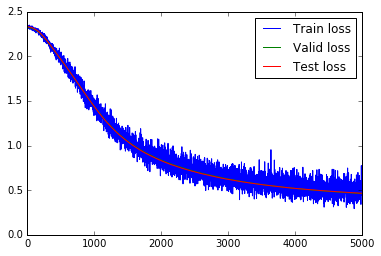

In [27]:
# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(nn.losses['train'], label='Train loss')
plt.plot(nn.losses['valid'], label='Valid loss')
plt.plot(nn.losses['test'], label='Test loss')
plt.legend()
plt.show()

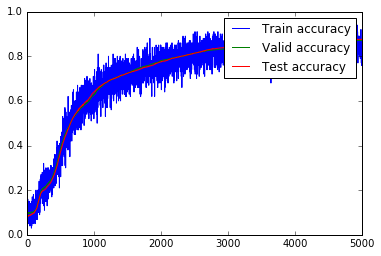

In [28]:
plt.plot(nn.losses['train_acc'], label='Train accuracy')
plt.plot(nn.losses['valid_acc'], label='Valid accuracy')
plt.plot(nn.losses['test_acc'], label='Test accuracy')
plt.legend()
plt.show()